# Text Classification with LSTM

In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Text processing
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}"
      "\n".format(str(device)))

Using device: cpu



# EDA of Raw Dataset

In [14]:
raw_data_path = "all-data.csv"

df = pd.read_csv(raw_data_path, encoding = "ISO-8859-1", names=['sentiment', "text"])

In [15]:
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [16]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["sentiment"].value_counts())
print(40*'-')
nr_categories = len(df["sentiment"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 4846
----------------------------------------
Split by category:
neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64
----------------------------------------
Number of categories: 3


# Preprocessing


In [17]:
# Drop rows with empty text
df.drop( df[df.text.str.len() < 5].index, inplace=True)

In [18]:
# Encode Label Columns
le = preprocessing.LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [19]:
# Trim text to first_n_words

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

df['text'] = df['text'].apply(trim_string)


In [20]:
df.to_csv("all-data-v1.csv",index=False)

In [21]:
import nltk
nltk.download('stopwords') # Download stopwords from NLTK 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanpua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ivanpua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ivanpua/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
import torchtext

from torchtext.data import Field, TabularDataset, BucketIterator
# import spacy
# spacy_tokeniser = spacy.load("en_core_web_sm")

def tokenise(sample):
    """
    Called before any processing of the text has occurred.
    """
    sample = re.sub("[!?.,@#$%\^*()';:/~<>]", '', sample) # remove punctuations
    sample = sample.replace('-', ' ') # replace 
    sample = sample.replace("&", 'and') # replace
    sample = sample.strip()
    processed = sample.split() # tokenise
        
    return processed

'''
Stemming and lemmatization does not always yield better results 
as they reduce the meaning of strings, making it harder for 
computer (and even humans) to comprehend

e.g. Original    : French fries are amazing 
     Preprocessed: France fry amazing 

'''
def preprocessing(sample):
    
    # Stemming (remove -ing, -ly, ...)
    
    ps = nltk.stem.porter.PorterStemmer()
    sample = [ps.stem(word) for word in sample]

    # Lemmatisation (convert the word into root word)
    
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    sample = [lem.lemmatize(word) for word in sample]
    
    return sample

In [23]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english') # from NLTK


In [24]:
label_field = Field(sequential=False, 
                    use_vocab=False, 
                    batch_first=True)
text_field = Field(tokenize=tokenise,
                   preprocessing = None,
                   lower=False, 
                   include_lengths=True, 
                   batch_first=True,
                   stop_words=stopWords
                  )

/Users/ivanpua/opt/anaconda3/envs/nlp-pytorch-legacy/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Load Data into DataLoader

In [25]:
%%time

fields = [('sentiment', label_field), ('text', text_field)]


dataset = TabularDataset('all-data-v1.csv', 
                         format='csv',
                         fields=fields,
                         skip_header=True
                        )

CPU times: user 56.7 ms, sys: 2.33 ms, total: 59 ms
Wall time: 58.5 ms


/Users/ivanpua/opt/anaconda3/envs/nlp-pytorch-legacy/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/ivanpua/opt/anaconda3/envs/nlp-pytorch-legacy/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [26]:
train, validate = dataset.split(split_ratio=0.8)

trainLoader, valLoader = BucketIterator.splits((train, validate),
                                                shuffle=True,
                                                batch_size=32,
                                                sort_key=lambda x: len(x.text),
                                                sort_within_batch=True)

/Users/ivanpua/opt/anaconda3/envs/nlp-pytorch-legacy/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [27]:
# Or use a pre-trained embeddings e.g. Glove, Fasttext

# Recommended because improve accuracy and reduce training time
from torchtext.vocab import GloVe
word_len = 50
wordVectors = GloVe(name='6B', dim=word_len)

In [28]:
text_field.build_vocab(train, vectors=wordVectors)

# Build Model

In [29]:
# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

#         self.embedding = nn.Embedding(len(text_field.vocab), 50)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=50,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 3)
        
        self.relu = nn.ReLU()

    def forward(self, text, text_len):

#         text_emb = self.embedding(text) used when you don't want to have pre-trained weights

        packed_input = pack_padded_sequence(text, text_len, batch_first=True, enforce_sorted=False)
#         packed_output, _ = self.lstm(packed_input)
#         output, _ = pad_packed_sequence(packed_output, batch_first=True)

#         out_forward = output[range(len(output)), text_len - 1, :self.dimension]
#         out_reverse = output[:, 0, self.dimension:]
#         out_reduced = torch.cat((out_forward, out_reverse), dim=1)
        x, (hidden, cn) = self.lstm(packed_input)

        """
        The forward network of the last LSTM layer (hidden[-1, :, :]) 
        contains information about previous inputs, 
        whereas the backward network (hidden[-2, :, :]) 
        contains information about following inputs.
        We take the last hidden state of the forward output and 
        the last hidden state of the backward output and merge them together.
        """
        
        out_reduced = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
#         text_fea = torch.squeeze(text_fea, 1) Only for binary labels
        text_out = self.relu(text_fea)

        return text_out
    
    


# Loss Function (off the shelf or custom)

In [30]:
import torch.nn.functional as F
class loss(nn.Module):
    """
    Class for creating the loss function.  The labels and outputs from your
    network will be passed to the forward method during training.
    https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/7
    """

    def __init__(self):
        super(loss, self).__init__()

    def forward(self, categoryOutput, categoryTarget):
        
        # Do not round to 0 or 1 here, only convert in the convertNetOutput method for Accuracy
        # rating_loss = F.binary_cross_entropy(ratingOutput.float(), ratingTarget.float())
        cat_loss = F.cross_entropy(categoryOutput.float(), categoryTarget.float())
        
        # total_loss = rating_loss + cat_loss
        
        return cat_loss


lossFunc = loss()

# Training Model

In [31]:
import torch.optim as toptim
model = LSTM()
model = model.to(device)
epochs = 30
lr= 1e-4
optimizer = toptim.Adam(model.parameters(), lr=lr)

In [32]:

# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [33]:
def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(), # or custom from above
          train_loader = trainLoader,
          valid_loader = valLoader,
          num_epochs = 5,
          eval_every = len(trainLoader) // 2,
          file_path = "./output/lstm",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        
        for (labels, (text, text_len)), _ in train_loader: 
                        
            labels = labels.to(device)
            text = text_field.vocab.vectors[text].to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.to(device)
                        text = text_field.vocab.vectors[text].to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len)
                        

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')



train(model=model, optimizer=optimizer, num_epochs=epochs)

/Users/ivanpua/opt/anaconda3/envs/nlp-pytorch-legacy/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/30], Step [61/3660], Train Loss: 1.0854, Valid Loss: 1.0511
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [1/30], Step [122/3660], Train Loss: 0.9947, Valid Loss: 0.9662
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [2/30], Step [183/3660], Train Loss: 0.9332, Valid Loss: 0.9197
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [2/30], Step [244/3660], Train Loss: 0.8874, Valid Loss: 0.8861
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [3/30], Step [305/3660], Train Loss: 0.8586, Valid Loss: 0.8605
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [3/30], Step [366/3660], Train Loss: 0.8480, Valid Loss: 0.8414
Model saved to ==> ./output/lstm/model.pt
Model saved to ==> ./output/lstm/metrics.pt
Epoch [4/30], Step [427/3660], Train Loss: 0.8154, Valid Loss: 0.

Model loaded from <== ./output/lstm/metrics.pt


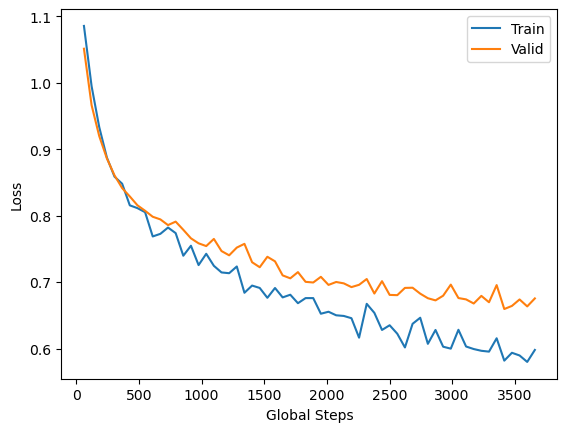

In [34]:
destination_folder = "./output/lstm"

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./output/lstm/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.4595    0.3091    0.3696       110
           1     0.7537    0.8981    0.8196       569
           2     0.6406    0.4793    0.5483       290

    accuracy                         0.7059       969
   macro avg     0.6179    0.5622    0.5792       969
weighted avg     0.6864    0.7059    0.6873       969



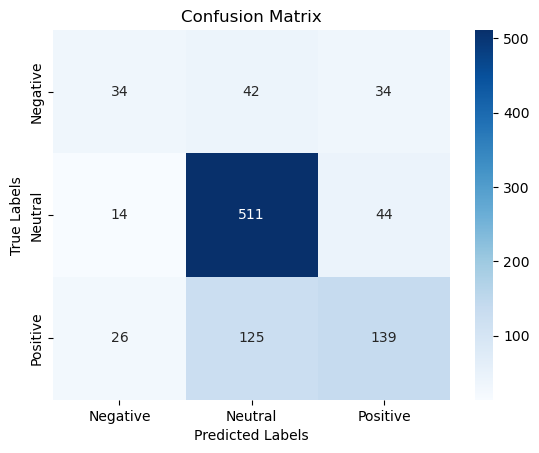

In [35]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader: 
            
            
            labels = labels.to(device)
            text = text_field.vocab.vectors[text].to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)
            

#             output = torch.round(output) # for binary labels
            
            # obtain index with the maximum probability, representing the predicted category 
            _, output = torch.max(output.data, 1)
            y_pred.extend(output.long().tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    
    
best_model = LSTM().to(device)
optimizer = toptim.Adam(best_model.parameters(), lr=lr)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, valLoader)